In [181]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.random as rand
import NSMap as ns
from datetime import date

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
filename = "..\Datasets\Portal_rodent.csv"
filename_trapping_dates = "..\Datasets\Portal_rodent_trapping.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
df = df.astype({"plot":str})
df_trapping_dates = pd.read_csv(filename_trapping_dates, encoding="utf-8", na_filter=False)

In [127]:
"""
Plan of Action: 
 1. Fix to just one species.
 2. Find all plots with fixed treatments over the whole series.
 3. Compare nonstationarity in plots where treatment
    changed versus those where treament stayed the same.

Expected Stationary Plots: 3, 4, 10, 11, 14, 15, 16, 17, 19, 21, 23
Expected Nonstationary Plots: 1, 2, 5-9, 12, 13, 18, 20, 22, 24

"""

stationary_plot_numbers = [3, 4, 10, 11, 14, 15, 16, 17, 19, 21, 23]
nonstationary_plot_numbers = [1, 2, 5, 6, 7, 8, 9, 12, 13, 18, 20, 22, 24]

In [208]:
df

,recordID,month,day,year,period,plot,note1,stake,species,sex,...,ltag,note3,prevrt,prevlet,nestdir,neststk,note4,note5,pit_tag,id
0,1,7,16,1977,1.0,2,,16,NA,M,...,0,,0,0,,0,,,FALSE,981505_NA_1
1,2,7,16,1977,1.0,3,,23,NA,M,...,0,,0,0,,0,,,FALSE,981506_NA_1
2,3,7,16,1977,1.0,2,,25,DM,F,...,0,,0,0,,0,,,FALSE,981507_DM_1
3,4,7,16,1977,1.0,7,,25,DM,M,...,0,,0,0,,0,,,FALSE,981508_DM_1
4,5,7,16,1977,1.0,3,,26,DM,M,...,0,,0,0,,0,,,FALSE,981509_DM_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76577,76682,7,19,2023,520.0,7,4,,,,...,,,,,,,,,,
76578,76683,7,19,2023,520.0,18,4,,,,...,,,,,,,,,,
76579,76684,7,19,2023,520.0,20,4,,,,...,,,,,,,,,,
76580,76685,7,19,2023,520.0,22,4,,,,...,,,,,,,,,,


In [128]:
# the first month of sampling was July of 1977 and it ends in July of 2023, therefore 

def get_species_series(species):
    total_months_elapsed = 46 * 12 + 1
    month_counter = 7
    year_counter = 1977

    table = df[["month", "day", "year", "period", "species"]].query("period >= 0")
    starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
    # table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
    table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)

    trapping_days = df_trapping_dates.query("sampled == 1")[["month", "year"]].to_numpy()

    ts = np.zeros(total_months_elapsed) * np.NAN
    ts_i = 0
    while not (month_counter > 7 and year_counter > 2023):
        did_sampling_occur = np.any(np.logical_and(trapping_days[:,0] == month_counter, trapping_days[:,1] == year_counter))
        if did_sampling_occur:
            is_sample_valid = np.logical_and(table_species[:,0] == month_counter, table_species[:,1] == year_counter)
            ts[ts_i] = np.sum(table_species[is_sample_valid])

        ts_i += 1
        month_counter += 1
        if month_counter > 12:
            month_counter = 1
            year_counter += 1

    t = np.linspace(0,1, num= total_months_elapsed)
    return (ts, t)

In [129]:
def get_plot_series(plot_num):
    total_months_elapsed = 46 * 12 + 1
    month_counter = 7
    year_counter = 1977

    table = df[["month", "day", "year", "period", "plot"]].query(f"period >= 0")
    starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
    
    # table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
    table_species = table.query(f"plot == \"{plot_num}\"")[["month","year"]].to_numpy(dtype=np.int64)
    # table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)
    
    trapping_days = df_trapping_dates.query("sampled == 1")[["month", "year"]].to_numpy()

    ts = np.zeros(total_months_elapsed) * np.NAN
    ts_i = 0
    while not (month_counter > 7 and year_counter > 2023):
        sampling_did_occur = np.any(np.logical_and(trapping_days[:,0] == month_counter, trapping_days[:,1] == year_counter))
        if sampling_did_occur:
            is_sample_valid = np.logical_and(table_species[:,0] == month_counter, table_species[:,1] == year_counter)
            ts[ts_i] = np.sum(table_species[is_sample_valid])

        ts_i += 1
        month_counter += 1
        if month_counter > 12:
            month_counter = 1
            year_counter += 1

    t = np.linspace(0,1, num= total_months_elapsed)
    return (ts, t)

In [130]:
def get_species_plot_series(species, plot_num):
    total_months_elapsed = 46 * 12 + 1
    month_counter = 7
    year_counter = 1977

    table = df[["month", "day", "year", "species", "period", "plot"]].query(f"period >= 0")
    starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
    
    # table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
    table_species = table.query(f"plot == \"{plot_num}\" and species == \"{species}\"")[["month","year"]].to_numpy(dtype=np.int64)
    # table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)
    
    trapping_days = df_trapping_dates.query("sampled == 1")[["month", "year"]].to_numpy()

    ts = np.zeros(total_months_elapsed) * np.NAN
    ts_i = 0
    while not (month_counter > 7 and year_counter > 2023):
        sampling_did_occur = np.any(np.logical_and(trapping_days[:,0] == month_counter, trapping_days[:,1] == year_counter))
        if sampling_did_occur:
            is_sample_valid = np.logical_and(table_species[:,0] == month_counter, table_species[:,1] == year_counter)
            ts[ts_i] = np.sum(table_species[is_sample_valid])

        ts_i += 1
        month_counter += 1
        if month_counter > 12:
            month_counter = 1
            year_counter += 1

    t = np.linspace(0,1, num= total_months_elapsed)
    return (ts, t)

In [131]:
# fetches the sum of all species from a particular control site
def get_species_control_series(species):
    control_only_plots = [4 , 11, 14, 17]
    
    ts, t = get_species_plot_series(species, control_only_plots[0])
    for plot_id in control_only_plots[1:]:
        ts += get_species_plot_series(species, plot_id)[0]
    
    return (ts, t)

In [203]:
# First we find the 3 most abundant species across the 4 control plots

all_species = df["species"].unique()
total_observed = np.zeros(all_species.shape)
for i, species in enumerate(all_species):
    ts, t = get_species_control_series(species)
    
    total_observed[i] = np.sum(ts, where=np.isfinite(ts))

In [204]:
sorted_indices = np.flip(np.argsort(total_observed))
all_species_sorted = all_species[sorted_indices]
total_observed_sorted = total_observed[sorted_indices]

three_most_abundant = all_species_sorted[:3]

In [205]:
three_most_abundant

array(['DM', 'PP', 'DO'], dtype=object)

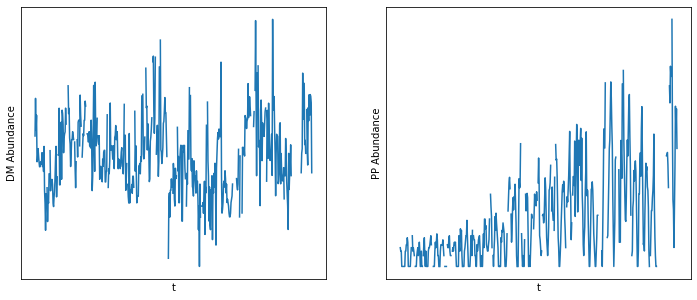

In [121]:
fig_ts, ax_ts = plt.subplots(1,2, figsize=(12,5))

for i, species in enumerate(three_most_abundant[:2]):
    ts_raw, t = get_species_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    ax_ts[i].plot(t, ts, label=species)
    ax_ts[i].set_ylabel(species+ " Abundance")
    
    ax_ts[i].set_yticks([])
    ax_ts[i].set_xticks([])
    ax_ts[i].set_xlabel("t")

In [94]:
E_max = 10
taus = np.arange(1,12)
r_sqrd_table = np.zeros((len(taus), 3))

In [177]:
# Determine tau and E

In [99]:
for i, species in enumerate(three_most_abundant):
    
    ts_raw, t = get_species_control_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))

    r_sqrds = [ns.get_delta_agg(ts, E_max, tau=tau, t=t,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:, i] = r_sqrds
    
np.savetxt("../results/portal_rodent_analysis/portal_rodent_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")

In [134]:
# Check Autocorrelation

autocorr_table = np.zeros((len(taus),3))

for i, species in enumerate(three_most_abundant):
    ts_raw, t = get_species_control_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    ts_noNANs = ts[np.isfinite(ts)]
    
    autocorr_table[:,i] = np.array([np.corrcoef(ts_noNANs[tau:],
                                           ts_noNANs[:-tau])[0,1]
                               for tau in taus])

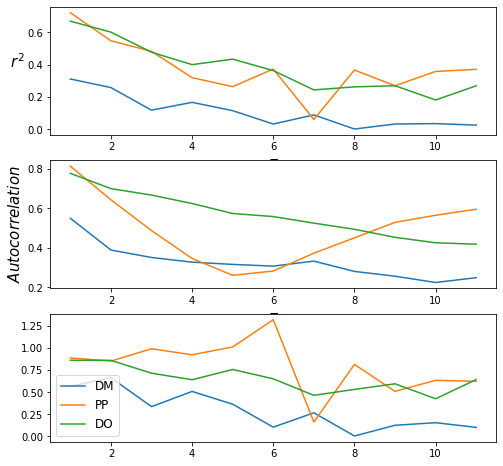

In [135]:
r_sqrd_table = np.loadtxt("../results/portal_rodent_analysis/portal_rodent_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(3,figsize=(8,8))

for i, species in enumerate(three_most_abundant):
    ax[0].plot(taus, r_sqrd_table[:,i], label=species)
    ax[1].plot(taus, autocorr_table[:,i], label=species)
    ax[2].plot(taus, r_sqrd_table[:,i] / autocorr_table[:,i], label=species)

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend(fontsize = 12)

In [136]:
"""
Tau determination: from the above plot, tau=2 is a great choice because it takes 
the autocorrelation down to 0.7 while preserving a quite strong prediction skill of 
around 0.81.

For E_max, we choose the above 7 the product of that is 49 and that gives a 
decently large embedding window
"""

tau = [2, 2, 2]
E_max = [10, 10, 10]

In [137]:
three_most_abundant

array(['DM', 'PP', 'DO'], dtype=object)

In [138]:
# Finally assess the nonstationarity

for i, species in enumerate(three_most_abundant):
    ts_raw, t = get_species_control_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    delta, theta, r_sqrd = ns.get_delta_agg(ts, E_max[i], tau=tau[i], t=t,
                                            return_forecast_skill=True)
    print(f"delta = {delta:.2f}, theta = {theta:.2f}, r_sqrd = {r_sqrd:.2f}")

delta = 0.00, theta = 0.00, r_sqrd = 0.26
delta = 9.22, theta = 0.00, r_sqrd = 0.55
delta = 1.22, theta = 1.05, r_sqrd = 0.60


Multiwindow Analysis of DM time series

In [145]:
year_steps = 24
maxLen = ts.shape[0]
lengths = np.arange(year_steps*4,maxLen+1,step=year_steps)

In [153]:
## Compute delta for each subseries, uncomment if you wish to run again
"""
for i, species in enumerate(three_most_abundant):
    ts_raw, t = get_species_control_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    E = 8
    tau = 2
    h = 0

    # length, starting index, delta, theta, r_sqrd
    n_rows = 210
    results = np.zeros((n_rows, 5))
    tally = 0

    for length in lengths:
        for start in np.arange(0, maxLen - length+1, step=year_steps):
            ts_chunk = ts[start:length+start]
            # plotTS(ts_chunk)
            delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, E, tau = tau, 
                                                 return_forecast_skill = True)
            results[tally] = np.array([length, start, delta, theta, r_sqrd])
            tally += 1
    np.savetxt(f"../results/portal_rodent_analysis/{species}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")
"""

In [161]:
lengths.shape

(20,)

In [197]:
# Convert the delta values for each subseries into a square matrix
# which is plotted using matplotlib's imshow.
def makeHeatMapPortal(results):
    nonstationarityHeatMap = np.zeros((20, 20)) * np.nan
    for l, o, d, t, r in results:
        i_length = 21-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

In [371]:
# Make the figure
def makeFigurePortal(nonstationarityHeatMap, ts, name, ax):
    
    filenames = {"D. merriami" : "Figure_S16",
                 "D. ordii" : "Figure_S17"}
    
    scaling = lengths[-1]
    
    # im = ax.imshow(np.zeros(nonstationarityHeatMap[:-2].shape), cmap=cm.Greys)
    im = ax.imshow(np.log(nonstationarityHeatMap+1), cmap=custom_cmap)
    ax.set_xticks(29/24 + 5 * np.arange(8))
    ax.set_yticks(np.arange(21, step=5))
    ax.set_xticklabels([])
    ax.set_yticklabels((np.flip(lengths)[::5] / 12).astype(int))
    ax.set_ylim(20,-1)
    ax.set_xlim(-1.1, 24.25)
    
    ax.set_ylabel("Time series length (years)",fontsize=15)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    sample_time = np.linspace(7/12 + 1977, 7/12 + 2023, num = 12 * 46 + 1)
    
    axTS.plot(sample_time, ts,c="dodgerblue")
    axTS.set_ylabel(name, fontsize=12, style="italic")
    axTS.set_xlabel("Start year",fontsize=15)
    # axTS.set_xticks(table[::4,0])
    axTS.set_yticks([])
    
    plt.savefig(f"../figures_eps/portal_multiwindow/{filenames[name]}.eps", format="eps", bbox_inches="tight", transparent=False, facecolor="white")
    plt.show()

In [372]:
# Make a custom orange to blue color scheme
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 
custom_cmap.set_bad("white", 1)

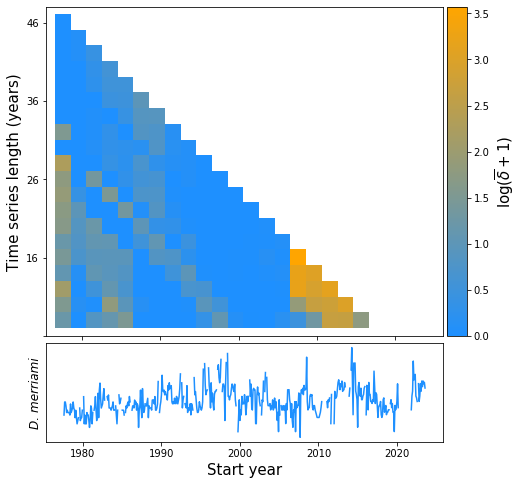

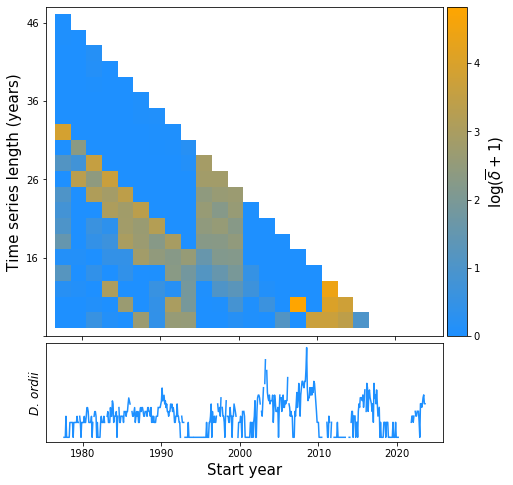

In [373]:
for i, species in enumerate(three_most_abundant[::2]):
    
    real_names = ["D. merriami", "D. ordii"]
    
    ts_raw, t = get_species_control_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    results = np.loadtxt(f"../results/portal_rodent_analysis/{species}_time_window.csv",
                             delimiter=",")

    fig, ax = plt.subplots(1, figsize = (8,8))

    nonstationarityHeatMap = makeHeatMapPortal(results)
    makeFigurePortal(nonstationarityHeatMap, ts, real_names[i], ax)
    
    plt.show()